In [1]:
import tensorflow

import pandas as pd
import numpy as np #데이터 배열화
import os #경로 설정용 
import keras #딥러닝용 패키지
import random #데이터 분산할 때 쓸 랜덤
import cv2 #이미지 읽기용
import math #연산용
import seaborn as sns #matplotlib에 다양한 시각화 기능이 추가된 패키지

from sklearn.metrics import confusion_matrix #분류의 정확성 평가
from sklearn.preprocessing import LabelBinarizer #데이터 전처리용
from sklearn.model_selection import train_test_split #데이터 분할용

import matplotlib.pyplot as plt #데이터 시각화용

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization #사용할 BN, ConV2 등의 계층
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout #사용할 레이어
from tensorflow.keras.applications.densenet import preprocess_input #tensor나 numpy배열 전처리용

from tensorflow.keras.preprocessing import image #이미지 데이터를 실시간으로 처리하기 위한 도구
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array #이미지 편집을 위한 제너레이터(Affine Transform)

from tensorflow.keras.models import Model #교육 및 추론 기능이 있는 개체로 레이어를 그룹화

from tensorflow.keras.optimizers import Adam #Adam 옵티마이저 사용. loss는 categorical_crossentropy 사용

#체크포인트를 두고 저장 + metric이 중지되면 학습률을 감소
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

import warnings #경고 무시
warnings.filterwarnings("ignore")

In [2]:
from keras_applications import resnet

In [3]:
model_d= tensorflow.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet', input_shape=(48, 48, 3))
x=model_d.output

x= GlobalAveragePooling2D()(x) #전역 평균 풀링 레이어 추가
x= BatchNormalization()(x) #배치 정규화 레이어
x= Dropout(0.3)(x)
#Fully Connected 레이어 추가
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.3)(x) #과적합 감소용 드롭아웃 레이어

preds=Dense(6,activation='softmax')(x) #FC-layer. 클래스가 7개이므로 softmax 7개 설정

In [4]:
model=Model(inputs=model_d.input,outputs=preds) 
model.summary() #모델 요약

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [5]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("emotion_FixedVer/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("emotion_FixedVer/"+img)))
    for i in path:
        image = cv2.imread("emotion_FixedVer/"+img+'/'+i)
        image = cv2.resize(image, (48,48))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['neutral', 'fearful', 'happy', 'sad', 'angry', 'surprised']


In [7]:
data = np.array(data, dtype="float32") / 255.0 #데이터 타입 변경 및 numpy 배열화
labels = np.array(labels) #라벨 numpy 배열화
mlb = LabelBinarizer() #데이터 전처리(원핫인코딩)
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0]


In [8]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.2,random_state=42) #train용과 test용으로 데이터셋 분리
print(xtrain.shape, xtest.shape)

(22294, 48, 48, 3) (5574, 48, 48, 3)


In [9]:

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2) #이미지 가공(학습률 향상을 위한 augmentation)


datagen.fit(xtrain)
# 모델 학습
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=100,
               verbose=2,
               validation_data=(xtest, ytest))

Epoch 1/100
174/174 - 39s - loss: 2.4545 - accuracy: 0.2105 - val_loss: 1529.2870 - val_accuracy: 0.1066
Epoch 2/100
174/174 - 24s - loss: 2.0812 - accuracy: 0.2870 - val_loss: 3274.5681 - val_accuracy: 0.2614
Epoch 3/100
174/174 - 24s - loss: 1.9303 - accuracy: 0.3114 - val_loss: 1288.2719 - val_accuracy: 0.1857
Epoch 4/100
174/174 - 24s - loss: 1.7793 - accuracy: 0.3450 - val_loss: 26.9988 - val_accuracy: 0.1579
Epoch 5/100
174/174 - 24s - loss: 1.7263 - accuracy: 0.3684 - val_loss: 2.8950 - val_accuracy: 0.3095
Epoch 6/100
174/174 - 24s - loss: 1.6204 - accuracy: 0.4156 - val_loss: 1.6452 - val_accuracy: 0.3793
Epoch 7/100
174/174 - 24s - loss: 1.5954 - accuracy: 0.4231 - val_loss: 1.4478 - val_accuracy: 0.4437
Epoch 8/100
174/174 - 24s - loss: 1.5997 - accuracy: 0.4294 - val_loss: 3.0459 - val_accuracy: 0.4519
Epoch 9/100
174/174 - 24s - loss: 1.5066 - accuracy: 0.4459 - val_loss: 1.9749 - val_accuracy: 0.4726
Epoch 10/100
174/174 - 26s - loss: 1.5297 - accuracy: 0.4401 - val_loss:

Epoch 81/100
174/174 - 24s - loss: 0.6358 - accuracy: 0.7857 - val_loss: 1.2093 - val_accuracy: 0.6114
Epoch 82/100
174/174 - 24s - loss: 0.5794 - accuracy: 0.7933 - val_loss: 1.1909 - val_accuracy: 0.6087
Epoch 83/100
174/174 - 24s - loss: 0.6358 - accuracy: 0.7776 - val_loss: 1.3681 - val_accuracy: 0.5798
Epoch 84/100
174/174 - 24s - loss: 0.5840 - accuracy: 0.7980 - val_loss: 1.1723 - val_accuracy: 0.6159
Epoch 85/100
174/174 - 24s - loss: 0.5290 - accuracy: 0.8165 - val_loss: 1.2332 - val_accuracy: 0.6030
Epoch 86/100
174/174 - 24s - loss: 0.5121 - accuracy: 0.8215 - val_loss: 1.2583 - val_accuracy: 0.6024
Epoch 87/100
174/174 - 24s - loss: 0.5282 - accuracy: 0.8195 - val_loss: 1.2477 - val_accuracy: 0.6032
Epoch 88/100
174/174 - 24s - loss: 0.5368 - accuracy: 0.8199 - val_loss: 1.2750 - val_accuracy: 0.6028
Epoch 89/100
174/174 - 24s - loss: 0.5419 - accuracy: 0.8118 - val_loss: 1.3338 - val_accuracy: 0.5874
Epoch 90/100
174/174 - 24s - loss: 0.5309 - accuracy: 0.8141 - val_loss: 

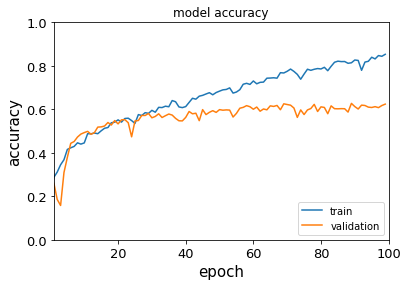

In [10]:
plt.title("model accuracy")
#plt.figure(10,20)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.axis([1, 100, 0, 1])
plt.ylabel("accuracy", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("epoch", fontsize=15)
plt.legend(["train", "validation"], loc="lower right") 
plt.show()

In [11]:
model.evaluate(xtest, ytest, batch_size = 32)

175/175 [==============================] - 7s 37ms/step - loss: 1.3207 - accuracy: 0.6240


[1.3207297325134277, 0.6239684224128723]

In [12]:
#완성도 확인
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]): #가장 큰 값을 찾아 인덱스 반환
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 5574 	accurately-predicted-data: 3478 	 wrongly-predicted-data:  2096
Accuracy: 62.397 %
